# Import

In [1]:
import os
import random

import pandas as pd
import numpy as np

from PIL import Image
from tqdm import tqdm

from sklearn.model_selection import train_test_split, KFold

import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch import nn, optim

from sklearn.metrics import log_loss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# 드라이브 -> 코랩으로 이미지 로드하는 속도가 느려서 학습 속도가 느려짐
# /content/dataset에 이미지를 저장하면 빨라짐
import zipfile

zip_file_name = '/content/drive/MyDrive/Colab Notebooks/HAI-Hecto-AI-Challenge-2025/data.zip'
extraction_dir = '/content/dataset'

# 압축 해제
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(extraction_dir)

# Hyperparameter Setting

In [4]:
CFG = {
    'IMG_SIZE': 224,
    'BATCH_SIZE': 64,
    'EPOCHS': 2,
    'FOLDS': 5,
    'LEARNING_RATE': 1e-4,
    'SEED' : 42
}

# Fixed RandomSeed

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(CFG['SEED']) # Seed 고정

# CustomDataset

In [6]:
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None, is_test=False):
        self.root_dir = root_dir
        self.transform = transform
        self.is_test = is_test
        self.samples = []

        if is_test:
            # 테스트셋: 라벨 없이 이미지 경로만 저장
            for fname in sorted(os.listdir(root_dir)):
                if fname.lower().endswith(('.jpg')):
                    img_path = os.path.join(root_dir, fname)
                    self.samples.append((img_path,))
        else:
            # 학습셋: 클래스별 폴더 구조에서 라벨 추출
            self.classes = sorted(os.listdir(root_dir))
            self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

            for cls_name in self.classes:
                cls_folder = os.path.join(root_dir, cls_name)
                for fname in os.listdir(cls_folder):
                    if fname.lower().endswith(('.jpg')):
                        img_path = os.path.join(cls_folder, fname)
                        label = self.class_to_idx[cls_name]
                        self.samples.append((img_path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        if self.is_test:
            img_path = self.samples[idx][0]
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image
        else:
            img_path, label = self.samples[idx]
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, label


# Data Load

In [7]:
train_root = '/content/dataset/data/train'
test_root = '/content/dataset/data/test'

In [8]:
train_transform = transforms.Compose([
    transforms.Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE'])),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                      std=[0.229, 0.224, 0.225])
    transforms.Normalize(mean=[0.42828095, 0.42260852, 0.4361709],
                         std=[0.32236168, 0.32402048, 0.32310665])
])

val_transform = transforms.Compose([
    transforms.Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE'])),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                      std=[0.229, 0.224, 0.225])
    transforms.Normalize(mean=[0.42828095, 0.42260852, 0.4361709],
                         std=[0.32236168, 0.32402048, 0.32310665])
])

In [9]:
# 전체 데이터셋 로드
full_dataset = CustomImageDataset(train_root, transform=None)
print(f"총 이미지 수: {len(full_dataset)}")

targets = [label for _, label in full_dataset.samples]
class_names = full_dataset.classes

# # Stratified Split
# train_idx, val_idx = train_test_split(
#     range(len(targets)), test_size=0.2, stratify=targets, random_state=42
# )

# # Subset + transform 각각 적용
# train_dataset = Subset(CustomImageDataset(train_root, transform=train_transform), train_idx)
# val_dataset = Subset(CustomImageDataset(train_root, transform=val_transform), val_idx)
# print(f'train 이미지 수: {len(train_dataset)}, valid 이미지 수: {len(val_dataset)}')


# # DataLoader 정의
# train_loader = DataLoader(train_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False)

총 이미지 수: 33114


# Model Define

In [10]:
class BaseModel(nn.Module):
    def __init__(self, num_classes):
        super(BaseModel, self).__init__()
        self.backbone = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
        self.backbone.classifier = nn.Linear(in_features=1024, out_features=num_classes, bias=True)

    def forward(self, x):
        x = self.backbone(x)
        return x


# Fine tuning

In [18]:
model = BaseModel(num_classes=len(class_names)).to('cpu')

for i, param in enumerate(model.parameters()):
  if i < 144:
    param.requires_grad = False

# Train/ Validation

In [19]:
# record model accuracy
import matplotlib.pyplot as plt
import seaborn as sns

val_acc_history = []
train_loss_history = []
val_loss_history = []

In [20]:
# model = BaseModel(num_classes=len(class_names))
# model_path = '/content/drive/MyDrive/Colab Notebooks/HAI-Hecto-AI-Challenge-2025/models/densenet121/epoch1_4fold_loss0.0287_model.pth'
# model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
print('[Execute Model Training on {}]'.format(device))

# 손실 함수, 옵티마이저
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=CFG['LEARNING_RATE'])

CFG['EPOCHS'] = 4

# KFold
kfold = KFold(n_splits=CFG['FOLDS'], shuffle=True, random_state=42)
folds = list(kfold.split(range(len(full_dataset))))

# 학습 및 검증 루프
for fold_idx, (train_idx, val_idx) in enumerate(folds):
    print(f'# {fold_idx+1} 번째 Fold')
    train_idx, val_idx = folds[fold_idx]
    train_dataset = Subset(CustomImageDataset(train_root, transform=train_transform), train_idx)
    val_dataset = Subset(CustomImageDataset(train_root, transform=val_transform), val_idx)
    # print(f'train 이미지 수: {len(train_dataset)}, valid 이미지 수: {len(val_dataset)}')
    # DataLoader 정의
    train_loader = DataLoader(train_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False)

    for epoch in range(CFG['EPOCHS']):
    # for epoch in range(7, 11):
        # Train
        model.train()
        train_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f"[Epoch {epoch+1}/{CFG['EPOCHS']}] Training"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)  # logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        all_probs = []
        all_labels = []

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"[Epoch {epoch+1}/{CFG['EPOCHS']}] Validation"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Accuracy
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

                # LogLoss
                probs = F.softmax(outputs, dim=1)
                all_probs.extend(probs.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct / total
        val_logloss = log_loss(all_labels, all_probs, labels=list(range(len(class_names))))

        train_loss_history.append(avg_train_loss)
        val_acc_history.append(val_accuracy)
        val_loss_history.append(val_logloss)

        # 결과 출력
        print(f"Train Loss : {avg_train_loss:.4f} || Valid Loss : {avg_val_loss:.4f} | Valid Accuracy : {val_accuracy:.4f}%")

        # Best model 저장
        # if val_logloss < best_logloss:
        # best_logloss = val_logloss
        torch.save(model.state_dict(), f'/content/drive/MyDrive/Colab Notebooks/HAI-Hecto-AI-Challenge-2025/models/densenet121/finetuning_epoch{epoch}_{fold_idx}fold_loss{val_logloss:.4f}_model.pth')
        # print(f"📦 Best model saved at epoch {epoch+1} (logloss: {val_logloss:.4f})")

[Execute Model Training on cuda]
# 1 번째 Fold


[Epoch 1/4] Validation: 100%|██████████| 104/104 [01:11<00:00,  1.46it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Train Loss : 4.8859 || Valid Loss : 3.4607 | Valid Accuracy : 51.8043%


[Epoch 2/4] Validation: 100%|██████████| 104/104 [01:01<00:00,  1.68it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Train Loss : 2.3657 || Valid Loss : 1.4387 | Valid Accuracy : 78.6955%


[Epoch 3/4] Validation: 100%|██████████| 104/104 [01:01<00:00,  1.69it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Train Loss : 0.9327 || Valid Loss : 0.7098 | Valid Accuracy : 87.3773%


[Epoch 4/4] Validation: 100%|██████████| 104/104 [01:00<00:00,  1.72it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Train Loss : 0.4037 || Valid Loss : 0.4926 | Valid Accuracy : 89.5365%
# 2 번째 Fold


[Epoch 1/4] Validation: 100%|██████████| 104/104 [01:00<00:00,  1.73it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Train Loss : 0.2795 || Valid Loss : 0.1534 | Valid Accuracy : 97.3124%


[Epoch 2/4] Validation: 100%|██████████| 104/104 [01:00<00:00,  1.72it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Train Loss : 0.1350 || Valid Loss : 0.1230 | Valid Accuracy : 97.0406%


[Epoch 3/4] Validation: 100%|██████████| 104/104 [01:01<00:00,  1.70it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Train Loss : 0.0758 || Valid Loss : 0.1063 | Valid Accuracy : 97.0708%


[Epoch 4/4] Validation: 100%|██████████| 104/104 [01:02<00:00,  1.66it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Train Loss : 0.0498 || Valid Loss : 0.1000 | Valid Accuracy : 97.2520%
# 3 번째 Fold


[Epoch 1/4] Validation: 100%|██████████| 104/104 [01:01<00:00,  1.69it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Train Loss : 0.0813 || Valid Loss : 0.0388 | Valid Accuracy : 99.3960%


[Epoch 2/4] Validation: 100%|██████████| 104/104 [01:00<00:00,  1.71it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Train Loss : 0.0361 || Valid Loss : 0.0457 | Valid Accuracy : 98.8827%


[Epoch 3/4] Validation: 100%|██████████| 104/104 [01:00<00:00,  1.71it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Train Loss : 0.0217 || Valid Loss : 0.0264 | Valid Accuracy : 99.4111%


[Epoch 4/4] Validation: 100%|██████████| 104/104 [01:01<00:00,  1.69it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Train Loss : 0.0268 || Valid Loss : 0.0301 | Valid Accuracy : 99.2149%
# 4 번째 Fold


[Epoch 1/4] Validation: 100%|██████████| 104/104 [01:01<00:00,  1.70it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Train Loss : 0.0453 || Valid Loss : 0.0217 | Valid Accuracy : 99.6376%


[Epoch 2/4] Validation: 100%|██████████| 104/104 [01:01<00:00,  1.70it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Train Loss : 0.0250 || Valid Loss : 0.0229 | Valid Accuracy : 99.4866%


[Epoch 3/4] Validation: 100%|██████████| 104/104 [01:01<00:00,  1.70it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Train Loss : 0.0166 || Valid Loss : 0.0194 | Valid Accuracy : 99.6376%


[Epoch 4/4] Validation: 100%|██████████| 104/104 [01:01<00:00,  1.68it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Train Loss : 0.0117 || Valid Loss : 0.0075 | Valid Accuracy : 99.8641%
# 5 번째 Fold


[Epoch 1/4] Validation: 100%|██████████| 104/104 [01:03<00:00,  1.64it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Train Loss : 0.0317 || Valid Loss : 0.0491 | Valid Accuracy : 98.8825%


[Epoch 2/4] Validation: 100%|██████████| 104/104 [01:00<00:00,  1.73it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Train Loss : 0.0285 || Valid Loss : 0.0198 | Valid Accuracy : 99.5168%


[Epoch 3/4] Validation: 100%|██████████| 104/104 [01:01<00:00,  1.70it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Train Loss : 0.0145 || Valid Loss : 0.0181 | Valid Accuracy : 99.4413%


[Epoch 4/4] Validation: 100%|██████████| 104/104 [01:00<00:00,  1.72it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Train Loss : 0.0067 || Valid Loss : 0.0070 | Valid Accuracy : 99.7735%


## Plot Acc, Loss

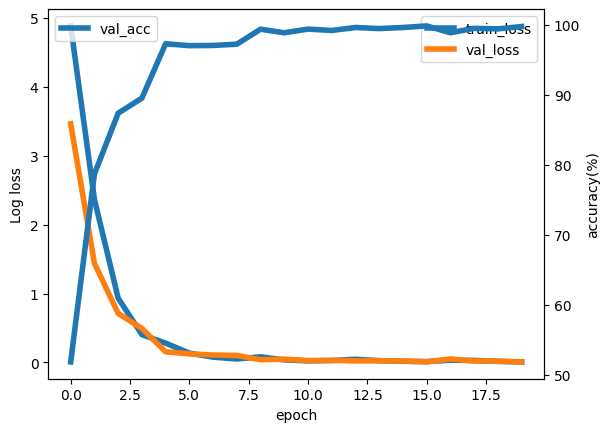

In [21]:
# plot model accuracy
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure()

ax1 = fig.add_subplot(1, 1, 1)
sns.set_palette('tab10')
chart1 = sns.lineplot(x=range(len(train_loss_history)), y=train_loss_history, label='train_loss', linewidth=4)
chart3 = sns.lineplot(x=range(len(val_loss_history)), y=val_loss_history, label='val_loss', linewidth=4)
ax1.set_ylabel('Log loss')
ax1.set_xlabel('epoch')
plt.legend()

ax2 = ax1.twinx()
chart2 = sns.lineplot(x=range(len(val_acc_history)), y=val_acc_history, label='val_acc', linewidth=4)
ax2.set_ylabel('accuracy(%)')
plt.legend()



# Inference

In [22]:
test_dataset = CustomImageDataset(test_root, transform=val_transform, is_test=True)
test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False)

In [24]:
# 저장된 모델 로드
model = BaseModel(num_classes=len(class_names))
model_path = '/content/drive/MyDrive/Colab Notebooks/HAI-Hecto-AI-Challenge-2025/models/densenet121/finetuning_epoch3_4fold_loss0.0070_model.pth'
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)

# 추론
model.eval()
results = []

with torch.no_grad():
    for images in tqdm(test_loader):
        images = images.to(device)
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)

        # 각 배치의 확률을 리스트로 변환
        for prob in probs.cpu():  # prob: (num_classes,)
            result = {
                class_names[i]: prob[i].item()
                for i in range(len(class_names))
            }
            results.append(result)

pred = pd.DataFrame(results)

100%|██████████| 130/130 [01:47<00:00,  1.21it/s]


# Submission

In [25]:
submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/HAI-Hecto-AI-Challenge-2025/submission/sample_submission.csv', encoding='utf-8-sig')

# 'ID' 컬럼을 제외한 클래스 컬럼 정렬
class_columns = submission.columns[1:]
pred = pred[class_columns]

submission[class_columns] = pred.values
submission_path = '/content/drive/MyDrive/Colab Notebooks/HAI-Hecto-AI-Challenge-2025/submission/densenet121_finetuning_0.0070.csv'
submission.to_csv(submission_path, index=False, encoding='utf-8-sig')